In [1]:
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
IMG_SIZE=28
LR=1e-3
MODEL_NAME='KAGGLEMNIST-{}{}.model'.format(LR,'CONV2')

In [2]:
df_train = pd.read_csv('C:/Kaggle_Datasets/MNIST/train.csv')
np_train=df_train.as_matrix()

In [8]:
labels_flat = df_train[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
labels_flat

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

In [9]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [10]:
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)
labels

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [6]:
train_images=np_train[:,1:].astype(np.uint8)
bum=np.resize(train_images,(42000,28,28))

In [7]:
count=0
train_data=[]
for i in labels: 
    train_data.append([bum[count],i])
    count=count+1
#labels[0]
#train_data

In [13]:
import tensorflow as tf
tf.reset_default_graph()

In [50]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import batch_normalization

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input') 

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = batch_normalization (convnet)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = batch_normalization (convnet)
convnet = dropout(convnet, 0.7)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = batch_normalization (convnet)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = batch_normalization (convnet)
convnet = dropout(convnet, 0.7)

convnet = fully_connected(convnet, 512, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 10, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='C:\Tensorboard_logs\MNIST\log')

In [51]:
train=train_data[:-6000]
test=train_data[-6000:]

In [52]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [62]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=5000, show_metric=True, run_id=MODEL_NAME)

Training Step: 10696  | total loss: 0.02309 | time: 5.968s
| Adam | epoch: 019 | loss: 0.02309 - acc: 0.9954 -- iter: 35968/36000
Training Step: 10697  | total loss: 0.03133 | time: 7.051s
| Adam | epoch: 019 | loss: 0.03133 - acc: 0.9943 | val_loss: 0.04266 - val_acc: 0.9888 -- iter: 36000/36000
--


In [64]:
model.save(MODEL_NAME)
##tensorboard --logdir=foo:C:\Tensorboard_logs\MNIST\log

INFO:tensorflow:C:\Users\William Jiang\Documents\TensorFlow-Tutorials\MNISTKaggle\KAGGLEMNIST-0.001CONV2.model is not in all_model_checkpoint_paths. Manually adding it.


In [63]:
#skip if want to load new model
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

model loaded!


In [65]:
df_test = pd.read_csv('C:/Kaggle_Datasets/MNIST/test.csv')
np_test=df_test.as_matrix()

In [66]:
test_images=np_test[:,:].astype(np.uint8)
bum_test=np.resize(test_images,(28000,28,28))
#bum_test=test_images.reshape(28000,28,28)
bum_test.shape

(28000, 28, 28)

In [67]:
ImgID=1
test_data=[]
for i in bum_test: 
    test_data.append([bum_test[ImgID-1],ImgID])
    ImgID=ImgID+1
#labels[0]
#test_data

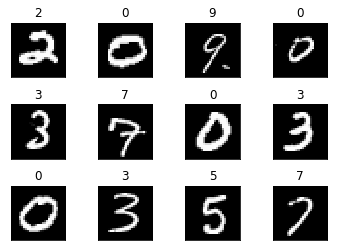

In [68]:
import matplotlib.pyplot as plt

# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()
fig.subplots_adjust(hspace=.5)
for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])
        
    y.imshow(orig,cmap='gray')
    plt.title(np.argmax(model_out))
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [69]:
with open('submission_file.csv','w') as f:
    f.write('ImageId,Label\n')
    
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):  
        img_num = data[1]
        img_data = data[0]
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])
        label_prediction=np.argmax(model_out)
        f.write('{},{}\n'.format(img_num,label_prediction))

100%|███████████████████████████████████| 28000/28000 [00:44<00:00, 624.02it/s]
